## Построение модели функции 3х- аргументов через NN

    датасеты грузятся через tf.dataset из кучки csv файлов
        

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

%matplotlib inline

## Создание данных

In [2]:
x = np.linspace(-5, 5, 50) 
y = np.linspace(-5, 5, 50) 
z = np.linspace(-5, 5, 50) 

x_m, y_m, z_m = np.meshgrid(x,y,z)

x_m = x_m.reshape(-1)
y_m = y_m.reshape(-1)
z_m = z_m.reshape(-1)

print('x_m:', x_m.shape, 'y_m:', y_m.shape ,'z_m', z_m.shape)
f = x_m**2. + 1/(y_m+6.) + x_m*z_m + np.exp(z_m)
f.shape

x_m: (125000,) y_m: (125000,) z_m (125000,)


(125000,)

In [3]:
df = pd.DataFrame({'x':x_m, 'y':y_m, 'z':z_m, 'f':f})
df.head()

,x,y,z,f
0,-5.0,-5.0,-5.000000,51.006738
1,-5.0,-5.0,-4.795918,49.987855
2,-5.0,-5.0,-4.591837,48.969318
3,-5.0,-5.0,-4.387755,47.951204
4,-5.0,-5.0,-4.183673,46.933610


In [4]:
df.to_csv('data/train.csv', header=False)

датасетик получился очень приличный, 9 Мб. тестовый буду генерить уже как-то отдельно, там не так важно пайпить

In [5]:
!cd data; split -l 1000 train.csv
# !ls -lh data

# нужно бить с сохранением строк - он не умеет строку из кусочков собирать
# специально делаю мелкие, чтобы понять как он их собирает

## Собираем datapipe

In [6]:
ds = tf.data.experimental.make_csv_dataset(
    'data/x*', 256,
    column_names = ['index','x','y','z','f'],
    label_name = 'f',
    select_columns=['x','y','z','f']
).repeat(1).shuffle(10000).cache()

In [7]:
data, label = next(iter(ds.take(1)))
data.keys(), label.numpy()[:10]

(odict_keys(['x', 'y', 'z']),
 array([ 0.8831061, 29.169384 , 10.948548 ,  8.402694 , 30.45867  ,
        38.96676  ,  4.6320977,  1.5279404, 13.75216  ,  1.7633439],
       dtype=float32))

In [8]:
def create_input_layer():
    """
    возвращает функцию, которая работает на бачах
    """
    v = {}
    for var in ['x','y','z']:
        v[var] = tf.feature_column.numeric_column(var)
    return tf.keras.layers.DenseFeatures([v[i] for i in v.keys()])    

In [9]:
input_layer = create_input_layer()

In [ ]:
#input_layer(data)

## Сначала пробую сделать все через Keras

In [11]:
model = tf.keras.models.Sequential([
    input_layer,
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])

history = model.fit(ds, epochs=20,steps_per_epoch=1500)

Epoch 1/20
1500/1500 [==============================] - 39s 26ms/step - loss: 143.2217 - mae: 5.4262 - mse: 143.2217
Epoch 2/20
1500/1500 [==============================] - 37s 25ms/step - loss: 1.4207 - mae: 0.6661 - mse: 1.4207
Epoch 3/20
1500/1500 [==============================] - 37s 24ms/step - loss: 0.2652 - mae: 0.3378 - mse: 0.2652
Epoch 4/20
1500/1500 [==============================] - 34s 23ms/step - loss: 0.1151 - mae: 0.2394 - mse: 0.1151
Epoch 5/20
1500/1500 [==============================] - 38s 25ms/step - loss: 0.1106 - mae: 0.2153 - mse: 0.1106
Epoch 6/20
1500/1500 [==============================] - 45s 30ms/step - loss: 0.0594 - mae: 0.1723 - mse: 0.0594
Epoch 7/20
1500/1500 [==============================] - 42s 28ms/step - loss: 0.0920 - mae: 0.1933 - mse: 0.0920
Epoch 8/20
1500/1500 [==============================] - 32s 21ms/step - loss: 0.0626 - mae: 0.1582 - mse: 0.0626
Epoch 9/20
1500/1500 [==============================] - 36s 24ms/step - loss: 0.0645 - mae: 

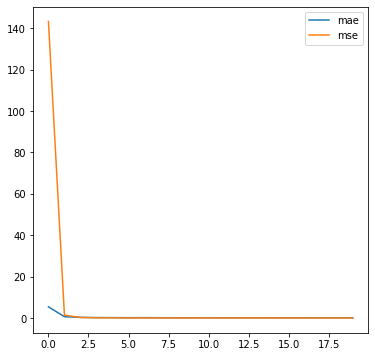

In [12]:
plt.figure(figsize=(6,6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['mse'], label='mse')
plt.legend()


## Пробуем предиктить

    сначала маленький тестовый датасет. 

In [13]:
x_test = tf.constant(np.random.choice(np.linspace(-5, 5, 5000), 500,  replace=False))
y_test = tf.constant(np.random.choice(np.linspace(-5, 5, 5000), 500,  replace=False))
z_test = tf.constant(np.random.choice(np.linspace(-5, 5, 5000), 500,  replace=False))

f_test = x_test**2. + 1/(y_test+6.) + x_test*z_test + np.exp(z_test)

print(x_test.shape, y_test.shape, z_test.shape)
f

(500,) (500,) (500,)


array([ 51.00673795,  49.98785524,  48.9693179 , ..., 146.72559731,
       170.08596835, 198.50406819])

In [14]:
X_test = tf.data.Dataset.from_tensor_slices({'x': x_test, 
                                             'y': y_test, 
                                             'z': z_test}).batch(500)
##  !!! помнить - нет батча - ничего и не выйдет !!!

In [15]:
batch = next(iter( X_test))
input_layer(batch)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(500, 3), dtype=float32, numpy=
array([[ 2.6815362 , -4.0178037 , -1.3132627 ],
       [ 2.6275256 ,  3.2076416 ,  4.5459094 ],
       [ 2.7235446 ,  3.3736746 ,  1.185237  ],
       ...,
       [-3.1436288 ,  2.7235446 ,  4.6679335 ],
       [ 3.3816764 ,  0.22904581, -4.495899  ],
       [-0.19703941, -2.9335868 , -4.8319664 ]], dtype=float32)>

In [16]:
y_hat = model.predict(X_test)

In [17]:
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()

print('MSE: {}, MAE: {}'.format(mse(y_test, y_hat), mae(y_test, y_hat)))

MSE: 1588.426025390625, MAE: 24.777408599853516


## Теперь аналогичная модельно руками, через GradientTape

    конечно суперкрасиво не получится, но это и не нужно

In [19]:
class MyNNmodel():
    def __init__(self):
        # веса модели
        self.w0 = tf.Variable(np.random.randn(128,3)*0.1,dtype=tf.float32)
        self.b0 = tf.Variable(tf.zeros([128,1], dtype=tf.float32))
        self.w1 = tf.Variable(np.random.randn(128,128)*0.1,dtype=tf.float32)
        self.b1 = tf.Variable(tf.zeros([128,1], dtype=tf.float32))
        self.w2 = tf.Variable(np.random.randn(1,128)*0.1,dtype=tf.float32)
        self.b2 = tf.Variable(tf.zeros([1,1], dtype=tf.float32))
        
    def forward_(self, X):
        X = tf.transpose(X)
        res = self.w0 @ X + self.b0
        res = 1./(1+tf.exp(-res)) # пусть все будет сигмоидой
        res = self.w1 @ res + self.b1
        res = 1./(1+tf.exp(-res))
        res = self.w2 @ res + self.b2
        return res
    
    def mse_loss(self, y, y_hat):
        return tf.reduce_mean((y-y_hat)**2)
    
    def fit(self, dataset, epochs = 10, steps_per_epoch = 1000, lr=0.001):
        for epoch in range(epochs):
            losses = []
            for step, (batch, y) in enumerate(dataset.take(steps_per_epoch)):
                # мы должны выдернуть из датасета батч и предикт. и посчитать потери
                X = input_layer(batch)
                with tf.GradientTape() as tape:
                    y_hat = self.forward_(X)
                    loss = self.mse_loss(y, tf.squeeze(y_hat))
                dw0, db0, dw1, db1, dw2, db2 = tape.gradient(loss, 
                                    [self.w0, self.b0, self.w1, self.b1, self.w2, self.b2])
                losses.append(loss)
                for t, g in zip((self.w0, self.b0, self.w1, self.b1, self.w2, self.b2),
                                 (dw0, db0, dw1, db1, dw2, db2)):
                    t.assign_sub(g*lr)
            
            print('epoch: {} mse_loss {}'.format(epoch, np.mean(loss)))
        return losses
    def predict(self,dataset):
        return self.forward_(dataset)
    

In [20]:
my_model = MyNNmodel()
losses = my_model.fit(ds)

epoch: 0 mse_loss 108.4256362915039
epoch: 1 mse_loss 110.18960571289062
epoch: 2 mse_loss 38.852012634277344
epoch: 3 mse_loss 15.917581558227539
epoch: 4 mse_loss 6.360286235809326
epoch: 5 mse_loss 4.725956916809082
epoch: 6 mse_loss 3.3328864574432373
epoch: 7 mse_loss 51.20990753173828
epoch: 8 mse_loss 5.943907260894775
epoch: 9 mse_loss 1.5656733512878418


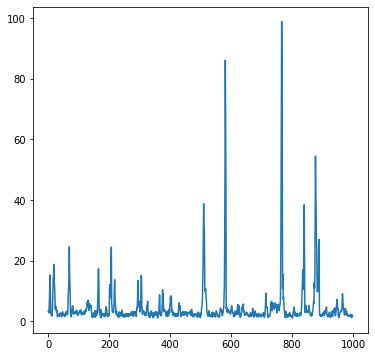

In [21]:
plt.figure(figsize=(6,6))
plt.plot(losses)

In [22]:
y_hat = my_model.predict(input_layer(batch))

In [23]:
mae = tf.keras.losses.MeanAbsoluteError()
mse = tf.keras.losses.MeanSquaredError()

print('MSE: {}, MAE: {}'.format(mse(y_test, y_hat), mae(y_test, y_hat)))

MSE: 1564.62548828125, MAE: 24.447294235229492
